# Speech Understanding 
# Lecture 11: The SpeechRecognition Module

### Mark Hasegawa-Johnson, KCGI

In today's lecture, we will learn how to use the <a href="https://pypi.org/project/SpeechRecognition/">Speech Recognition</a> module in order to access high-performance commercial and open-source speech recognizers.

Here are the contents:
1. <a href="#section1">Installing SpeechRecognition</a>
1. <a href="#section2">Using SpeechRecognition</a>
1. <a href="#section3">Installing PyAudio</a>
1. <a href="#section4">Handling microphone issues using exception processing</a>
1. <a href="#homework">Homework</a>


<a id='section1'></a>

## 1. Installing SpeechRecognition

The `SpeechRecognition` module can be used to call a wide variety of speech-to-text systems.  By default, it uses the Google speech recognizer, which requires web access, but you can set it to use a local speech recognizer on your own machine.  It is installed using pip:


In [1]:
!pip install SpeechRecognition

<a id='section2'></a>

## 2. Using SpeechRecognition

In order to use the `SpeechRecognition` module, we need to create two types of objects.

1. A `Recognizer` object contains the information necessary to do speech recognition.  For example, this object knows whether you're using Google or some other speech recognizer (by default, Google).
1. You also need some type of audio source.  There are two main types of audio source:
    1. A `Microphone` object gets audio from your computer's microphone
    1. An `AudioFile` object gets audio from an audio file

Once you have created both types of objects, then you need to do three things:
1. Get audio from the audio source into the speech recognizer, and
1. Convert the audio into text,
1. Print out what the person said

Here is an example:

In [2]:
import speech_recognition as sr

# Create a recognizer instance
r = sr.Recognizer()

# Use the audio file as the audio source
audio_file_path = "264752__copyc4t__phone-messages-english-and-italian.flac"

# Use a try-except block to handle exceptions that might occur
try:
    with sr.AudioFile(audio_file_path) as source:
        # Record the audio from the file
        audio = r.record(source)
        # Recognize the speech using Google's speech recognition
        text = r.recognize_google(audio)
        print('The person in this audio file said:', text)
except sr.UnknownValueError:
    # Handle the exception if the recognizer could not understand the audio
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    # Handle the exception if there was a problem with the request to Google's service
    print("Could not request results from Google Speech Recognition service; {0}".format(e))
except OSError as e:
    # Handle the exception if there is an issue with the FLAC conversion utility
    print("OSError: {0}".format(e))


The person in this audio file said: thank you please wait for assistance


And... it worked!  Except, did the speaker in this audio file really repeat the word "assistance" twice?   Let's find out, by loading the audio file, looking at it, and listening to it.

This particular audio file was downloaded from https://freesound.org/people/copyc4t/sounds/264752/, and it is available under a CC-BY 4.0 license, so if you use it, you should say that you got it from copyc4t at freesound.

Length is 188928 , rate is  22050 , duration is 8.568163265306122


Text(0.5, 0, 'Time (seconds)')

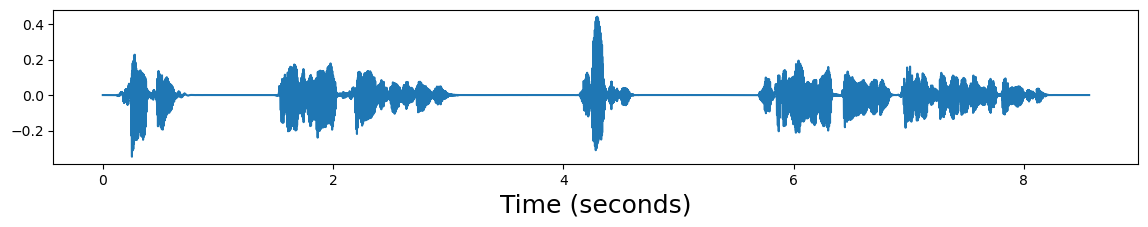

In [3]:
import librosa
import numpy as np
y, sr = librosa.load('264752__copyc4t__phone-messages-english-and-italian.flac')
print('Length is',len(y),', rate is ',sr,', duration is',len(y)/sr)
time_axis = np.arange(len(y))/sr

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,2))
subplot = fig.subplots(1,1)
subplot.plot(time_axis, y)
subplot.set_xlabel('Time (seconds)',fontsize=18)

In [4]:
import IPython
IPython.display.Audio(data=y,rate=sr)

As you can see, this file has two parts:

* The first four seconds are in English
* The rest is in Italian

So we should probably tell the `Recognizer` to recognize the first part in English, and the last part in Italian.  We can do that using the following keyword arguments:

* The `record` method takes `offset` and `duration` arguments, in seconds.  See https://realpython.com/python-speech-recognition/ 
* The `recognize_google` method takes `language` as an argument.  The language codes you can use are listed here: https://cloud.google.com/speech-to-text/docs/speech-to-text-supported-languages

In [6]:
import speech_recognition as sr

with sr.AudioFile("264752__copyc4t__phone-messages-english-and-italian.flac") as source:
    r = sr.Recognizer()
    # First, recognize the English part
    audio = r.record(source, duration=4)
    try:
        text = r.recognize_google(audio, language='en')
        print('The English part of this audio file says:', text, '.\n')
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))

    # Second, recognize the Italian part
    # We need to adjust the offset to the end of the first part
    audio = r.record(source, offset=4)
    try:
        text = r.recognize_google(audio, language='it')
        print('The Italian part of this audio file says:', text, '.\n')
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
    except sr.RequestError as e:
        print("Could not request results from Google Speech Recognition service; {0}".format(e))


The English part of this audio file says: thank you please wait for assistance .

Google Speech Recognition could not understand audio


<a id='section3'></a>

## 3. Installing PyAudio

Recognizing from the microphone just requires us to use a `Microphone` object as the source, instead of an `AudioFile` object.  But there are some special problems to pay attention to.

First, in order for `speech_recognizer` to listen to your microphone, you need to have PyAudio installed.  The following code should install PyAudio for you.  

In [1]:
!pip install pyaudio

Now try the following, to see if it works:

In [2]:
import speech_recognition
mic = speech_recognition.Microphone()

If that worked, then all is well. If that failed, then it might mean you need to re-start your kernel.  Try the following:

* Go to the **Kernel** menu at the top of this page
* Choose **Change kernel**
* Choose any one of the listed kernels.  For example, you could choose **Python3 (ipykernel)** or you could choose **Python [conda env:root]**

This will re-start your kernel, and re-load everything.  Hopefully, now PyAudio and `speech_recognition.Microphone()` will work.

If they don't work, (1) you won't be able to do speech recognition from your microphone, but (2) you can still do the homework, because the homework only uses audio files.


<a id='section4'></a>

## 4. Handling microphone issues using exception processing

Before we start recognizing, we should adjust for background noise.  This is done using the command `r.adjust_for_ambient_noise(source)`.

Second, what happens if the speech recognizer listens for a while, and then doesn't understand what it hears?  If this happens, either the `listen` function or the `recognize_google` function will raise an exception.

Python's exception handling is exceptional.  I strongly recommend that you learn about it, by studying this tutorial: https://docs.python.org/3/tutorial/errors.html.  But in case you don't have time, here are the basics:

* Any function can raise an exception using the syntax `raise ...`, where `...` is some subclass of the `exception` class.  For example, a typical exception is `raise RuntimeError`.
* If that function was not inside a `try` envelope, then the code stops running at that point, and prints an error.
* It that function was inside a `try` envelope, then python checks after the `try` to see if there is an `except` clause.  If there is, then instead of just stopping execution, python runs the code in the `except` clause.

This syntax allows us to basically ignore more speech recognition errors.  Our strategy will be to put the `r.listen` and `r.recognize_google` functions inside a `try` clause, inside a `while True` loop.

* If there is a `speech_recognizer.WaitTimeoutError`, it means that the `listen` command listened for too long but didn't hear anything.  In that case, we use `continue` to go back to the beginning of the loop and try again.
* If there is a `speech_recognizer.RequestError`, it means that the `recognize_google` command couldn't reach google over the internet.  In that case, we use `continue` to go back to the beginning of the loop and try again.
* If there is a `speech_recognizer.UnknownValueError`, it means that the `recognize_google` command couldn't understand what you said.  In that case, use use `continue` to go back to the beginning of the loop and try again.
* If none of the above is true, then we assume the text is correct, so we use a `break` command to break out of the loop and print the result.


In [3]:
import speech_recognition
r = speech_recognition.Recognizer()

while True:
    print('Python is listening...')
    with speech_recognition.Microphone() as source:
        r.adjust_for_ambient_noise(source)
        try:
            audio = r.listen(source)
            text = r.recognize_google(audio, language='en')
        except speech_recognition.UnknownValueError:
            print('I did not understand that, I will try again')
            continue
        except sr.RequestError:
            print('Sorry, I could not reach the internet, I will try again')
            continue
        except sr.WaitTimeoutError:
            continue
        break

print('You said:',text)


Python is listening...
I did not understand that, I will try again
Python is listening...
I did not understand that, I will try again
Python is listening...
I did not understand that, I will try again
Python is listening...


NameError: name 'sr' is not defined

<a id='homework'></a>

## Homework

Open the file called `homework11.py`.

This file should `def` a function called `transcribe_wavefile`, with the following signature:

In [4]:
import homework11, importlib
importlib.reload(homework11)
help(homework11.transcribe_wavefile)

Help on function transcribe_wavefile in module homework11:

transcribe_wavefile(filename, language='en')
    Use sr.Recognizer.AudioFile(filename) as the source,
    recognize from that source,
    and return the recognized text.
    
    @params:
    filename (str) - the filename from which to read the audio
    language (str) - the language of the audio (optional; default is English)
    
    @returns:
    text (str) - the recognized speech



Test whether your code works by running the following block:

In [5]:
importlib.reload(homework11)

text = homework11.transcribe_wavefile("264752__copyc4t__phone-messages-english-and-italian.flac",'it')
print(text)

Thank you please wait for Sisters grazie lo preghiamo di attendere per ricevere assistenza


### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [6]:
import importlib, grade
importlib.reload(grade)

...
----------------------------------------------------------------------
Ran 3 tests in 5.618s

OK


3 successes out of 3 tests run
Score: 100%


...
----------------------------------------------------------------------
Ran 3 tests in 5.628s

OK


3 successes out of 3 tests run
Score: 100%


<module 'grade' from '/Users/yuuyoshiyasu/Downloads/intro_speech_understanding/2023_fall/lec11/grade.py'>

In [7]:
!python grade.py

...
----------------------------------------------------------------------
Ran 3 tests in 5.456s

OK
3 successes out of 3 tests run
Score: 100%
